In [1]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.graphics.regressionplots import abline_plot
from statsmodels.stats.outliers_influence import OLSInfluence


# 0. Prepare the data

In [11]:
?pd.read_csv

In [12]:
# Read the data: the advertising budget for different media -> sales
# PATH = "lab/data/"
PATH = "./"
df_raw = pd.read_csv(f'{PATH}Advertising.csv')
df_raw.head(n=5)

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [13]:
# Remove the first column and see the summary
df = df_raw.drop(['Unnamed: 0'],axis=1)
df.head(n=5)

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [14]:
# Look for null values
df.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

In [15]:
# add null value to verify
# df.at[0,'TV']=np.nan
# df.head(n=5)
# df.isnull().sum()

# 1. Fit a linear model

In [16]:
?dmatrices
# Patsy is a library for describing statistical models (especially linear models)

In [17]:
def myLinReg(model_formula, df, printMSE = False):
    """
    Function returns the summary for fitted linear model.
    
    Parameter "model_formula" should be a patsy formula describing the model.
    Parameter "df" is a dataframe.
    """
    
    # Split the data into training (80%) and validation set (20%)
    mask = np.random.rand(len(df)) < 0.8
    train = df[mask]
    valid = df[~mask]
        
    # Prepare the data (dmatrices is from patsy library)
    y_train, X_train = dmatrices(model_formula, data=train, return_type='dataframe')   
    y_valid, X_valid = dmatrices(model_formula, data=valid, return_type='dataframe')

    # Train the model
    model = sm.OLS(y_train, X_train) 
    result = model.fit() 

    
    # Show MSE for training set
    if(printMSE==True):
        y_train_pred = result.predict(X_train)
        print(f'MSE_Train: {metrics.mean_squared_error(y_train, y_train_pred)}')

    # Show MSE for validation set
    if(printMSE==True):
        y_valid_pred = result.predict(X_valid)
        print(f'MSE_Test: {metrics.mean_squared_error(y_valid, y_valid_pred)}\n')

    # Retrun fitted model summary
    return result


In [18]:
models = [
    'sales ~ TV',
    'sales ~ radio',
    'sales ~ newspaper',
    'sales ~ TV + radio + newspaper',
    'sales ~ TV * radio * newspaper',
    'sales ~ I(np.log(TV)) + TV:radio'
]

                 TV     radio  newspaper     sales
TV         1.000000  0.054809   0.056648  0.782224
radio      0.054809  1.000000   0.354104  0.576223
newspaper  0.056648  0.354104   1.000000  0.228299
sales      0.782224  0.576223   0.228299  1.000000


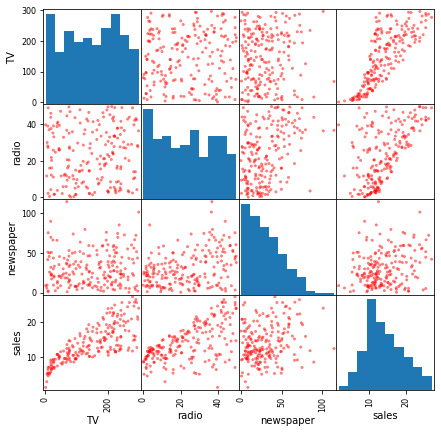

In [19]:
# Look into scatterplots and correclation matrix, you may remove some features
print(df.corr())
axis = pd.plotting.scatter_matrix(df,color="red",figsize=(7,7))

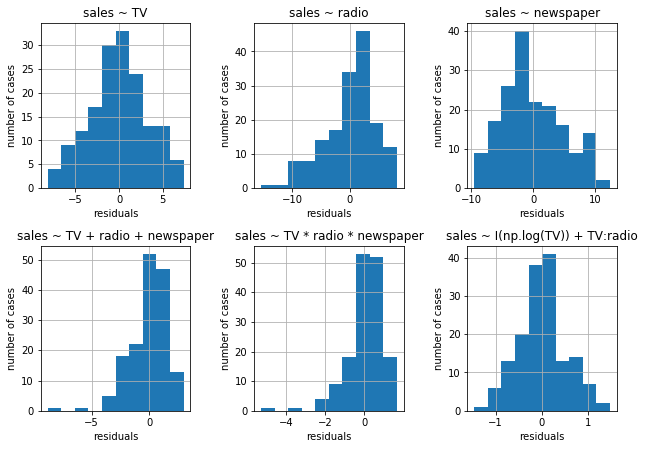

In [20]:
# Verify that residuals follow normal distribiution and look for outliers
fig = plt.figure(figsize=(9, 9))
i=1
for model in models:
    fig.add_subplot(3, 3, i)
    ax = myLinReg(model,df).resid.hist()  
    ax.set_xlabel("residuals")
    ax.set_ylabel("number of cases")
    ax.set_title(models[i-1])
    plt.tight_layout()
    i=i+1
    
  

MSE_Train: 0.23437341663307848
MSE_Test: 0.21392005934479466



155   -0.134207
98    -0.053681
8     -0.051416
108   -0.041447
192   -0.029802
Name: Leverage, dtype: float64

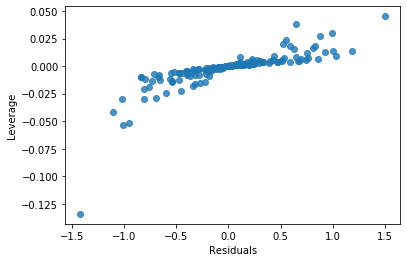

In [21]:
# Look for high leverage points that you might want to remove

result = myLinReg(models[5], df, printMSE=True)
residuals = pd.Series(result.resid, name="Residuals")
leverage = pd.Series(OLSInfluence(result).influence, name = "Leverage")
_ = sns.regplot(residuals, leverage, fit_reg=False)

leverage.sort_values().head()


# 2. Model analysis

In [22]:
# See the model summary, analyze and rethink the model
result = myLinReg(models[5], df, printMSE=True)
result.summary()

MSE_Train: 0.2325327771534867
MSE_Test: 0.2217328224350382



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     9833.
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          2.41e-167
Time:                        10:22:26   Log-Likelihood:                -111.71
No. Observations:                 162   AIC:                             229.4
Df Residuals:                     159   BIC:                             238.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.4480      0.194     12.587      0.000       2.064       2.832
I(np.log(TV))     1.5600      0.046     34.097      0.000       1.470       1.650
TV:radio          0.0012   1.33e-05     91.996      0.000       0.001       0.001
==============================================================================
Omnibus:                        2.250   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.325   Jarque-Bera (JB):                2.093
Skew:                           0.032   Prob(JB):                        0.351
Kurtosis:                       3.553   Cond. No.                     2.65e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

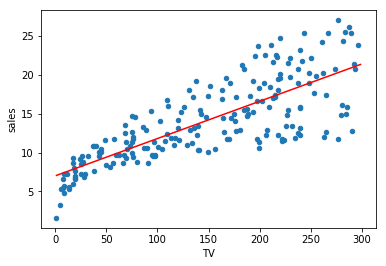

In [63]:
# Plot fitted points vs real values
result = myLinReg(models[0], df)

# scatter-plot data
ax = df.plot(x='TV', y='sales', kind='scatter')

# plot regression line on the same axes
p = result.params
x = np.arange(1, 300)
ax = ax.plot(x, p.Intercept + p.TV  * x, 'r' )